In [ ]:
import pandas as pd
import json
import os
import hdbscan
import seaborn as sns
import umap.umap_ as umap  

from transformers import pipeline

import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer


/home/gabrielbach/Gabriel/work/tech-tendencies/.tech_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = "./dataset/data"
data = []

for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
            json_data = json.load(f)
            data.append(json_data)

df = pd.DataFrame(data)

def combine_text(row):
    claim = row.get("claims", "")
    abstract = row.get("abstract", "")
    return claim + " " + abstract

df["combined_text"] = df.apply(combine_text, axis=1)
corpus = df["combined_text"].tolist()
corpus[0]

'1. A semiconductor device, comprising: a device die; a molding layer surrounding the device die; a plurality of first vertical conductive structures formed within the molding layer; and a plurality of second vertical conductive structures formed within the molding layer; wherein the first vertical conductive structures and the second vertical conductive structures are interlaced with each other, and an insulating structure is formed between the first vertical conductive structures and the second vertical conductive structures. 2. The semiconductor device of claim 1, wherein a molding compound is applied in the molding layer to surround the device die, and to form the insulating structure. 3. The semiconductor device of claim 2, wherein the molding compound comprises polymer or silica. 4. The semiconductor device of claim 1, wherein a molding compound is applied in the molding layer to surround the device die, and a dielectric material is applied in the molding layer to form the insula

In [3]:

model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
embeddings = model.encode(corpus, batch_size=64, show_progress_bar=True)
print("Embeddings shape:", embeddings.shape)


Batches: 100%|██████████| 419/419 [13:37<00:00,  1.95s/it]


Embeddings shape: (26808, 384)


In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,  # detecta clusters pequenos
    min_samples=2,       # menos exigência de densidade
    metric='euclidean'
)

#df['cluster'] = labels

In [ ]:
# Step 1: Reduce embeddings to 2D using UMAP
reducer = umap.UMAP(
    n_neighbors=30,      # balances local vs global structure
    min_dist=0.0,        # makes clusters tighter
    metric='euclidean',  # same metric as HDBSCAN
    random_state=42
)
embedding_2d = reducer.fit_transform(embeddings)
print("2D embedding shape:", embedding_2d.shape)

# Step 2: Create a DataFrame for plotting
df_vis = pd.DataFrame({
    'x': embedding_2d[:,0],
    'y': embedding_2d[:,1],
    'cluster': labels
})

/home/gabrielbach/Gabriel/work/tech-tendencies/.tech_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


2D embedding shape: (26808, 2)


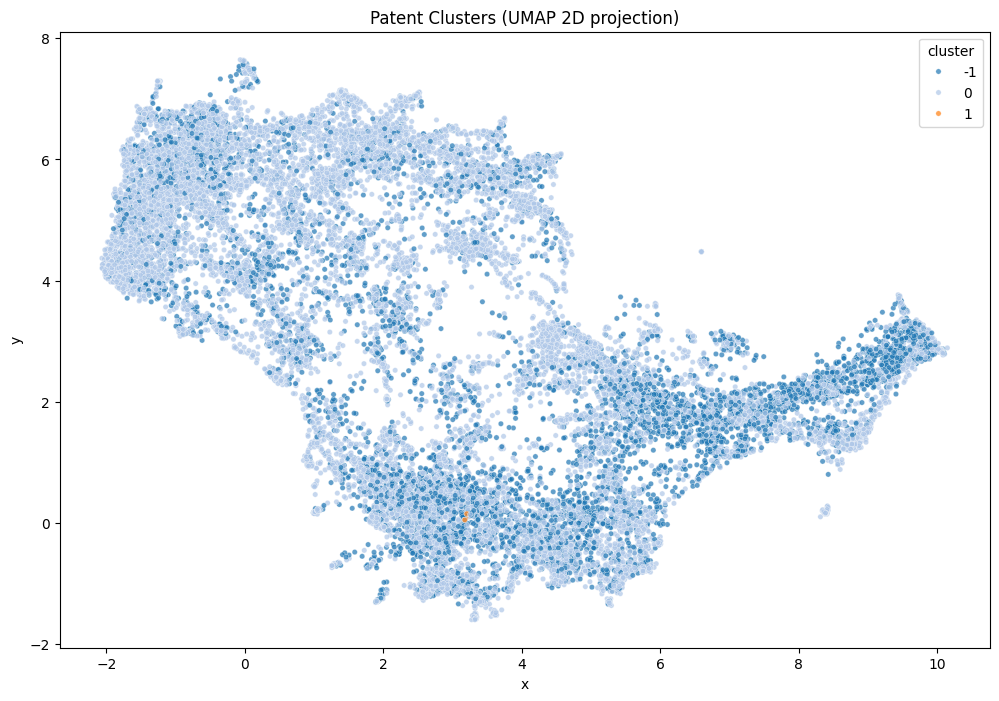

In [ ]:

# Step 3: Plot clusters
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_vis,
    x='x',
    y='y',
    hue='cluster',
    palette='tab20',
    legend='full',
    s=15,
    alpha=0.7
)
plt.title("Patent Clusters (UMAP 2D projection)")
plt.show()


In [ ]:
summarizer = pipeline("summarization", model="turingmachine/hupd-t5-small", device=-1)

def get_cluster_text(df, cluster_label, max_docs=20):
    cluster_texts = df[df['cluster'] == cluster_label]['combined_text'].tolist()
    cluster_text = " ".join(cluster_texts[:max_docs])
    return cluster_text

def label_cluster(cluster_text):
    summary = summarizer(cluster_text, max_length=50, min_length=20, do_sample=False)
    return summary[0]['summary_text']

cluster_labels = {}
for cluster in sorted(df['cluster'].unique()):
    if cluster == -1:
        continue  # skip noise
    text = get_cluster_text(df, cluster)
    label = label_cluster(text)
    cluster_labels[cluster] = label

df['cluster_label'] = df['cluster'].map(cluster_labels).fillna("Noise")

# -------------------------------
# Step 7: Display cluster summary
# -------------------------------
summary_table = df.groupby('cluster_label').agg(
    patents_count=('combined_text', 'count'),
    sample_text=('combined_text', lambda x: x.iloc[0][:200] + "...")
).reset_index()

print(summary_table.head(20))

Device set to use cpu


KeyError: 'cluster'